## Introduction

In this notebook, I will develop and test a Recurrent Neural Network (RNN) model to classify tweets for the "Natural Language Processing with Disaster Tweets" challenge on Kaggle (https://www.kaggle.com/c/nlp-getting-started/overview). This is a Natural Language Processing (NLP) task, as the goal is to interpret the text of the tweets and determine whether or not they are referring to real disasters. 

First, I will import the relevant libraries:

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

A quick look at the training data shows a dataset of 7613 tweets, with columns for the id number, keyword, location, and text of each tweet. In addition, the "target" column provides the training labels, indicating whether each tweet is about a real disaster (1) or not (0).

In [4]:
data = pd.read_csv("train.csv")
print(len(data))
data.sample(20)

7613


,id,keyword,location,text,target
4267,6061,heat%20wave,Malaysia/Jordan,It's kinda cool tonight. Is the heat wave fina...,1
636,921,bioterrorism,NaN,@ONU_France 74/75 Bioterrorism on '@Rockefelle...,0
4773,6792,lightning,"Holland MI via Houston, CLE",Corey Robinson having some solid reps at RT al...,0
3459,4948,exploded,WonderlandÛÓ ?????? ???? ??????,My head exploded i swear,0
2978,4275,drowning,NaN,Louis in red jacket round 2 aka drowning in my...,0
5104,7281,nuclear%20disaster,NaN,Fukushima 'mutant vegetable' images sweep acro...,1
3451,4935,exploded,NaN,The Dress Memes Have Officially Exploded On Th...,0
4372,6211,hijacker,NaN,Governor allows parole for California school b...,0
2100,3016,death,The UK,I liked a @YouTube video from @jeromekem http:...,0
5871,8388,ruin,NaN,You can only make yourself happy. Fuck those t...,0


## Exploratory Data Analysis

Non-disaster tweets outnumber disaster tweets in the dataset by about a 4:3 ratio:

In [5]:
data['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

An analysis of the word counts of the tweets shows a roughly normal distribution in word count for both disaster and non-disaster tweets, although it appears that disaster tweets have a slightly narrower distribution. In particulat, tweets with 5 or fewer words are overwhelmingly non-disaster.

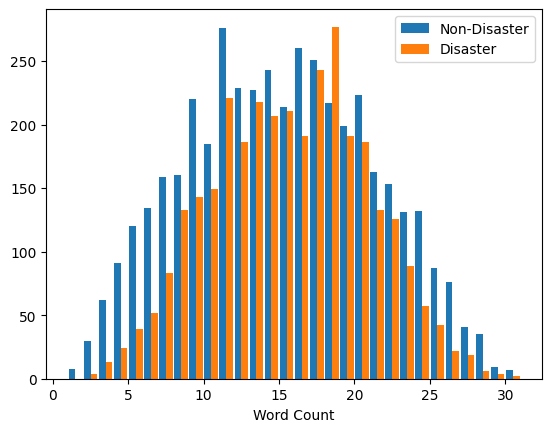

In [6]:
def word_count(text):
    words = text.split()
    return len(words)

wc0 = data[data['target'] == 0]['text'].apply(word_count).to_list()
wc1 = data[data['target'] == 1]['text'].apply(word_count).to_list()

plt.hist([wc0, wc1], bins=30, label=['Non-Disaster','Disaster'], rwidth=0.9)
plt.legend()
plt.xlabel('Word Count')
plt.show()

Looking at the 'location' column, there are a large number of missing values (2533 out of 7613) and a large number of unique values (3342). There is also an issue of inconsistent formating, with some entries specifying a country while others specify a state or city. This column will require some cleaning if it is to be used.

In [7]:
data['location'].value_counts(dropna=False)

location
NaN                             2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: count, Length: 3342, dtype: int64

The 'keyword' column has a much smaller number of missing values (61) and unique values (222).

In [8]:
data['keyword'].value_counts(dropna=False)

keyword
NaN                      61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 222, dtype: int64

## Data Preprocessing

Before training a model on the text of the tweets, I will have to convert the text into a suitable form. First, to reduce the text to its most relevant words, I will remove "stop words", which are common words such as the ones shown below:

In [9]:
#!pip install nltk
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words[:50]

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn']

The function below applies several operations to clean the text. First, words are converted to lower case, so that upper and lower case versions of the same word are treated as the same word in the model. Punctuation marks are also removed to prevent words followed by them to be treated differently. I also removed the symbols "#", "@", and "http" from words, but included them as separate strings, since their placement might be relevant to the model.

In [10]:
def Clean_text(text):
    words = []
    for word in text.split():

        #Convert to lower case
        word = word.lower()
        
        #Remove punctuation marks at the ends of words
        if word[-1] in ['.', ',', ':', '?', '!']:
            word = word[:-1]
            
        #Remove single-character words and stop words
        if len(word) < 2:
            continue
        if word in stop_words:
            continue
            
        #Add symbols as separate words
        if word[0] == '#' or word[0] == '@':
            words.append(word[0])
            word = word[1:]            
        if word[0:5] == 'http:':
            words.append(word[0:5])
            word = word[5:]
        
        words.append(word)
        
    return ' '.join(words)

data['Clean_text'] = data['text'].apply(Clean_text)

In [11]:
data.head()

,id,keyword,location,text,target,Clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason # earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked 'shelter place' notified offic...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive # wildfires evacuation o..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby # alaska smoke # wildfires...


Next, I split the data into a training and validation set based on an 80:20 ratio:

In [87]:
n = int(0.8*len(data))
df_shuffled = data.sample(frac=1).reset_index(drop=True)
data_train = df_shuffled[:n]
data_val = df_shuffled[n:]
print(len(data_train), len(data_val))

6090 1523


Finally, to prepare the data for the RNN model, I converted the text to integers using Keras' Tokenizer. I selected 10,000 for the num_words parameter, so that only the 10,000 most common words in the dataset would be included in the final preprocessed data. The final format for the input data is a sequence of integers, padded with zeroes to match the length of the longest sequence in the dataset.

In [88]:
def train_test(data, max_words):
    
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(data["Clean_text"])

    X_train = tokenizer.texts_to_sequences(data_train["Clean_text"])
    y_train = data_train["target"]
    X_val = tokenizer.texts_to_sequences(data_val["Clean_text"])
    y_val = data_val["target"]

    max_length = int(max([len(x) for x in X_train]))
    X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
    X_val = pad_sequences(X_val, maxlen=max_length, padding='post')

    return X_train, y_train, X_val, y_val

max_words = 10000
X_train, y_train, X_val, y_val = train_test(data, max_words)

In [89]:
X_train 

array([[  13, 1057, 1718, ...,    0,    0,    0],
       [1402,  490, 7227, ...,    0,    0,    0],
       [ 234, 3305,  281, ...,    0,    0,    0],
       ...,
       [1364,  640, 4442, ...,    0,    0,    0],
       [1662,  320,    3, ...,    0,    0,    0],
       [ 234,    0,    0, ...,    0,    0,    0]], dtype=int32)

## Model Building - LSTM

The first model that I decided to try was a Long Short-Term Memory (LSTM) model, a type of RNN that is designed to capture long-term dependencies in the sequence inputted to the model. A key component of the model is the embedding layer, which transforms the integer-coded words into multi-dimensional vectors that are updated during training, allowing the model to learn relationships between words. I chose to set the embedding dimension as 1/100th of the vocabulary size. 

In [90]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=max_words//100))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [91]:
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6002 - loss: 0.6411 - val_accuracy: 0.8162 - val_loss: 0.4346
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8684 - loss: 0.3337 - val_accuracy: 0.7761 - val_loss: 0.4897
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9238 - loss: 0.2348 - val_accuracy: 0.7879 - val_loss: 0.5153
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9411 - loss: 0.1627 - val_accuracy: 0.7997 - val_loss: 0.5894
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9528 - loss: 0.1459 - val_accuracy: 0.7728 - val_loss: 0.7737
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9678 - loss: 0.0973 - val_accuracy: 0.7853 - val_loss: 0.8408
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9690 - loss: 0.0807 - val_accuracy: 0.7531 - val_loss: 0.8804
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9729 - loss: 0.0787 - val_accuracy: 0.7656 - v

In [92]:
def plot_history(model_history):
    train_acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    n = len(train_acc)
    epoch = range(1, n+1)

    plt.plot(epoch, train_acc, label='Training Accuracy')
    plt.plot(epoch, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(0, n+1, 2))
    plt.show()

def Best_acc(model_history):
    best_acc = 0
    best_epoch = 0
    val_acc = model_history.history['val_accuracy']
    
    for i in range(len(val_acc)):
        if val_acc[i] > best_acc:
            best_acc = val_acc[i]
            best_epoch = i+1

    print("Best Epoch: " + str(best_epoch) + ", Accuracy = " + str(best_acc))
    return best_acc, best_epoch

def CFM(y_true, y_pred):
    cm = confusion_matrix(y_val, yp)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

The results of this first run of LSTM show a modest 81.6% validation accuracy achieved on the first epoch of training. From there, the validation accuracy declines as the training accuracy improves, suggesting that the model is overfitting.

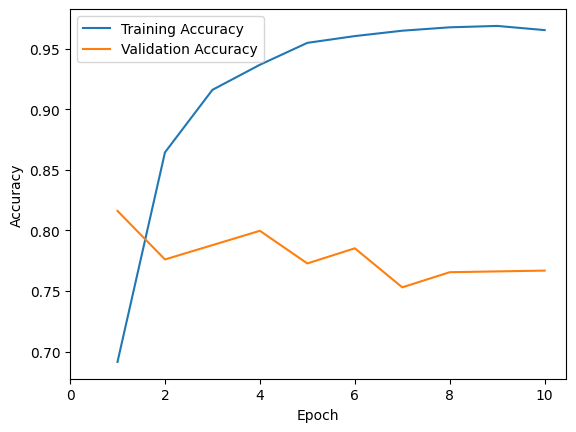

Best Epoch: 1, Accuracy = 0.8161523342132568


(0.8161523342132568, 1)

In [93]:
plot_history(model.history)
Best_acc(model.history)

The confusion matrix shows a significant imbalance in the direction of the errors; there are more false negatives than false positives.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


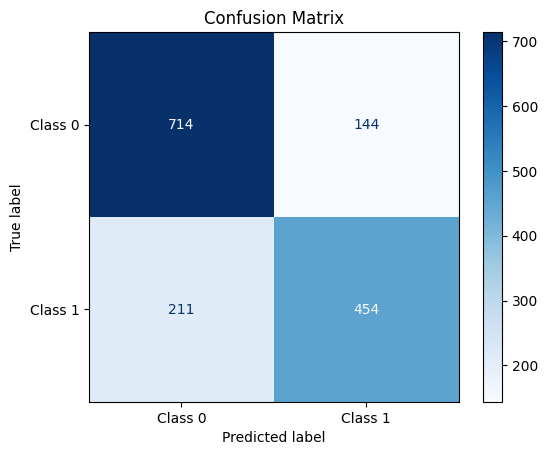

In [95]:
yp = model.predict(X_val) > 0.5
CFM(y_val, yp)

There are several hyperparamters to tune to try to address the overfitting problem. One approach is to include fewer words from the text and by reducing the size of the max_words parameter in the embedding layer. Another approach is to add a dropout layer to reduce the reliance of the model on specific neurons. I will also try varying the number of LSTM layers in the model and the batch size for training. The code below runs a parameter sweep testing three different values each for four hyperparameters. 

In [97]:
word_max = [ 1000, 5000, 10000 ]
batch_size = [ 32, 64, 128 ]
n_layers = [ 32, 64, 128 ]
dropout = [ 0.0, 0.2, 0.4 ]

best_params = [ 0, 0, 0, 0 ]
best_acc = 0
best_epoch = 0

for w in word_max:
    for b in batch_size:
        for l in n_layers:
            for d in dropout:
                X_train, y_train, X_val, y_val = train_test(data, w)

                model = Sequential()
                model.add(Embedding(input_dim=max_words, output_dim=max_words//100))
                model.add(LSTM(l, dropout=d))
                model.add(Dense(1, activation='sigmoid'))
                model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
                model.fit(X_train, y_train, epochs=10, batch_size=b, validation_data=(X_val, y_val), verbose=0)

                print(w,b,l,d)
                acc, epoch = Best_acc(model.history)
                if acc > best_acc:
                    best_params = [ w, b, l, d ]
                    best_acc = acc
                    best_epoch = epoch

print("word_max = ", best_params[0])
print("batch size = ", best_params[1])
print("n_layers = ", best_params[2])
print("dropout = ", best_params[3])
print("Accuracy = ", best_acc)

1000 32 32 0.0
Best Epoch: 3, Accuracy = 0.8102429509162903
1000 32 32 0.2
Best Epoch: 3, Accuracy = 0.8063033223152161
1000 32 32 0.4
Best Epoch: 5, Accuracy = 0.8056467771530151
1000 32 64 0.0
Best Epoch: 4, Accuracy = 0.8089297413825989
1000 32 64 0.2
Best Epoch: 3, Accuracy = 0.8102429509162903
1000 32 64 0.4
Best Epoch: 2, Accuracy = 0.813525915145874
1000 32 128 0.0
Best Epoch: 5, Accuracy = 0.8049901723861694
1000 32 128 0.2
Best Epoch: 2, Accuracy = 0.8089297413825989
1000 32 128 0.4
Best Epoch: 3, Accuracy = 0.8069599270820618
1000 64 32 0.0
Best Epoch: 5, Accuracy = 0.8023637533187866
1000 64 32 0.2
Best Epoch: 4, Accuracy = 0.8089297413825989
1000 64 32 0.4
Best Epoch: 2, Accuracy = 0.8102429509162903
1000 64 64 0.0
Best Epoch: 3, Accuracy = 0.8148391246795654
1000 64 64 0.2
Best Epoch: 3, Accuracy = 0.8089297413825989
1000 64 64 0.4
Best Epoch: 5, Accuracy = 0.8102429509162903
1000 64 128 0.0
Best Epoch: 4, Accuracy = 0.803676962852478
1000 64 128 0.2
Best Epoch: 1, Accurac

From the output above, it appears that tuning the hyperparamters has little effect on the performance of the model, with validation accuracy scores staying in the 79% - 82% range for all 81 combinations of parameters.

## Model Building - GRU

Next, I will try a different model architecture, using a Gated Recurrant Unit (GRU) instead of an LSTM. The GRU is a simpler model with fewer parameters, so perhaps it will be less likely to overfit to the training data. 

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5634 - loss: 0.6868 - val_accuracy: 0.5634 - val_loss: 0.6854
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5891 - loss: 0.6630 - val_accuracy: 0.8142 - val_loss: 0.4550
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8501 - loss: 0.3772 - val_accuracy: 0.8050 - val_loss: 0.4451
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9120 - loss: 0.2473 - val_accuracy: 0.8096 - val_loss: 0.4784
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9400 - loss: 0.1854 - val_accuracy: 0.7846 - val_loss: 0.5421
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9601 - loss: 0.1299 - val_accuracy: 0.7859 - val_loss: 0.6305
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9650 - loss: 0.1019 - val_accuracy: 0.7689 - val_loss: 0.6982
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9700 - loss: 0.0911 - val_accuracy: 0.7695 - v

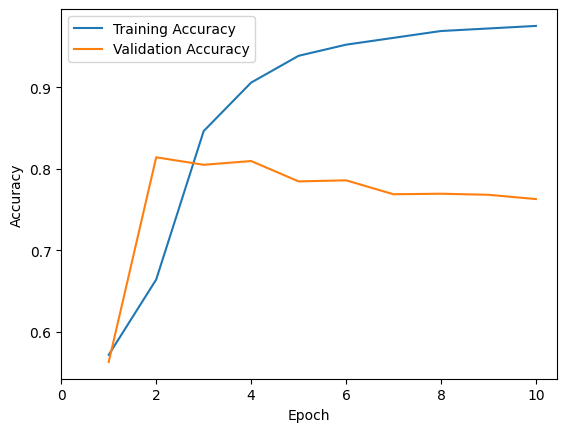

Best Epoch: 2, Accuracy = 0.8141825199127197


(0.8141825199127197, 2)

In [100]:
max_words = 10000
X_train, y_train, X_val, y_val = train_test(data, max_words)

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=max_words//100))
model.add(GRU(64))  # <-- swapped LSTM for GRU
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

plot_history(model.history)
Best_acc(model.history)

On the first try, the GRU model is no more accurate than the LSTM. It is notable, however, that it takes more than one epoch to achieve the best validation accuracy, suggesting that it is not overfitting as quickly as the LSTM. I will now repeat the same hyperparameter tuning procedure for the GRU. 

In [101]:
word_max = [ 1000, 5000, 10000 ]
batch_size = [ 32, 64, 128 ]
n_layers = [ 32, 64, 128 ]
dropout = [ 0.0, 0.2, 0.4 ]

best_params = [ 0, 0, 0, 0 ]
best_acc = 0
best_epoch = 0

for w in word_max:
    for b in batch_size:
        for l in n_layers:
            for d in dropout:
                X_train, y_train, X_val, y_val = train_test(data, w)

                model = Sequential()
                model.add(Embedding(input_dim=max_words, output_dim=max_words//100))
                model.add(GRU(l, dropout=d))
                model.add(Dense(1, activation='sigmoid'))
                model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
                model.fit(X_train, y_train, epochs=10, batch_size=b, validation_data=(X_val, y_val), verbose=0)

                print(w,b,l,d)
                acc, epoch = Best_acc(model.history)
                if acc > best_acc:
                    best_params = [ w, b, l, d ]
                    best_acc = acc
                    best_epoch = epoch

print("word_max = ", best_params[0])
print("batch size = ", best_params[1])
print("n_layers = ", best_params[2])
print("dropout = ", best_params[3])
print("Accuracy = ", best_acc)

1000 32 32 0.0
Best Epoch: 3, Accuracy = 0.8076165318489075
1000 32 32 0.2
Best Epoch: 4, Accuracy = 0.8076165318489075
1000 32 32 0.4
Best Epoch: 2, Accuracy = 0.8063033223152161
1000 32 64 0.0
Best Epoch: 3, Accuracy = 0.8030203580856323
1000 32 64 0.2
Best Epoch: 6, Accuracy = 0.803676962852478
1000 32 64 0.4
Best Epoch: 3, Accuracy = 0.8089297413825989
1000 32 128 0.0
Best Epoch: 1, Accuracy = 0.8082731366157532
1000 32 128 0.2
Best Epoch: 4, Accuracy = 0.8043335676193237
1000 32 128 0.4
Best Epoch: 4, Accuracy = 0.8076165318489075
1000 64 32 0.0
Best Epoch: 3, Accuracy = 0.8063033223152161
1000 64 32 0.2
Best Epoch: 6, Accuracy = 0.8056467771530151
1000 64 32 0.4
Best Epoch: 3, Accuracy = 0.8089297413825989
1000 64 64 0.0
Best Epoch: 2, Accuracy = 0.8076165318489075
1000 64 64 0.2
Best Epoch: 2, Accuracy = 0.8049901723861694
1000 64 64 0.4
Best Epoch: 5, Accuracy = 0.8082731366157532
1000 64 128 0.0
Best Epoch: 3, Accuracy = 0.8076165318489075
1000 64 128 0.2
Best Epoch: 5, Accura

Once again, tweaking hyperparamters does not make a large difference in the performance of the model. Overall, the LSTM and GRU architectures show a similar level of accuracy. For the final results, I will use the best-performing GRU model as it is more computationally efficient than the LSTM. 

Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5470 - loss: 0.6870 - val_accuracy: 0.5634 - val_loss: 0.6852
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6155 - loss: 0.6512 - val_accuracy: 0.8030 - val_loss: 0.4553
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8578 - loss: 0.3531 - val_accuracy: 0.8096 - val_loss: 0.4382


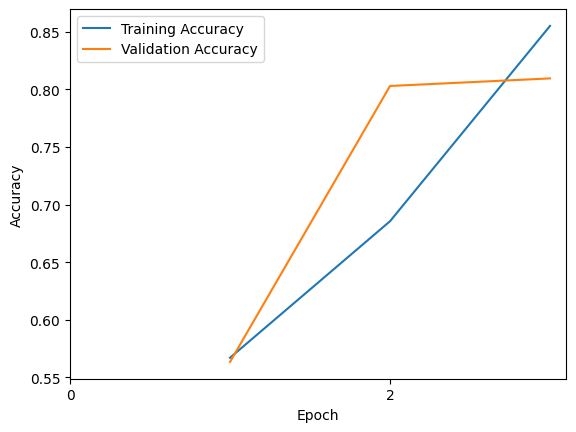

Best Epoch: 3, Accuracy = 0.8095863461494446
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


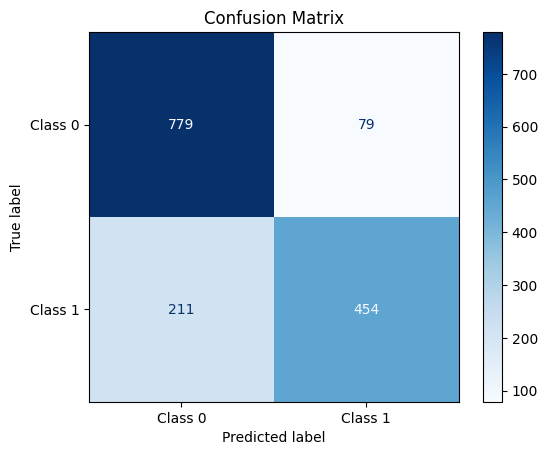

In [150]:
tokenizer = Tokenizer(num_words=best_params[0])
tokenizer.fit_on_texts(data["Clean_text"])

X_train = tokenizer.texts_to_sequences(data_train["Clean_text"])
y_train = data_train["target"]
X_val = tokenizer.texts_to_sequences(data_val["Clean_text"])
y_val = data_val["target"]

max_length = int(max([len(x) for x in X_train]))
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post')

model = Sequential()
model.add(Embedding(input_dim=best_params[0], output_dim=best_params[0]//100))
model.add(GRU(best_params[2], dropout=best_params[3])) 
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_params[1], validation_data=(X_val, y_val))

plot_history(model.history)
Best_acc(model.history)
yp = model.predict(X_val) > 0.5
CFM(y_val, yp)

The confusion matrix again shows more false negatives than false positives, which means that the accuracy of the model might be improved by lowering the probability threshold for a positive classification. In the code below, I will search for the ideal threshold for accuracy as well as F1-score, the metric used in the Kaggle competition. 

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


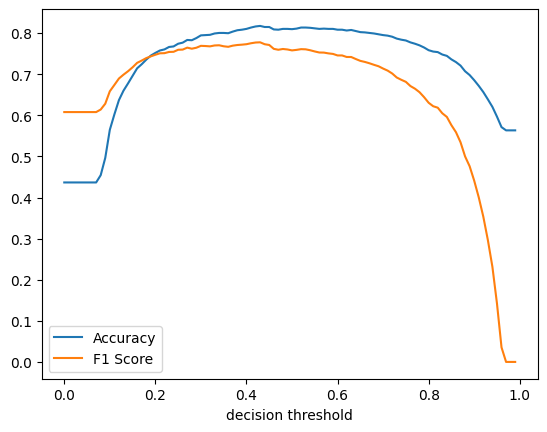

Best accuracy = 0.8174655285620486 , Threshold = 0.43
Best F1 Score = 0.7776 , Threshold = 0.43


In [151]:
thresh = [ 0.01*i for i in range(100) ] 
acc = []
f1 = []
yp = model.predict(X_val)[:,0]
n = len(yp)

for th in thresh:
    yp_bin = yp > th

    acc.append(sum(yp_bin == y_val)/n)

    tp = sum(yp_bin * y_val)
    fp = sum(yp_bin - y_val == 1)
    fn = sum(yp_bin - y_val == -1)

    f1.append(tp/(tp + 0.5*(fp + fn)))

plt.plot(thresh, acc, label='Accuracy')
plt.plot(thresh, f1, label='F1 Score')
plt.xlabel('decision threshold')
plt.legend()
plt.show()

best_acc = max(acc)
best_f1 = max(f1)
print("Best accuracy =",best_acc, ", Threshold =",0.01*acc.index(best_acc))
print("Best F1 Score =",best_f1, ", Threshold =",0.01*f1.index(best_f1))

I will now apply this model with a decision threshold of 0.43 to the test data.

In [164]:
test_data = pd.read_csv("test.csv")
test_data['Clean_text'] = test_data['text'].apply(Clean_text)

X_test = tokenizer.texts_to_sequences(test_data["Clean_text"])
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')
yp = model.predict(X_test)[:,0]
yp_bin = yp > 0.43

submission = test_data[['id']]
submission['target'] = [int(i) for i in yp_bin] 
submission.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/tmp/ipykernel_5585/1175433633.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['target'] = [int(i) for i in yp_bin]


,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [165]:
submission.to_csv('submission.csv')

## Conclusion
For this project, I built and trained a fairly accuracte RNN model to perform NLP on tweets and classify whether or not they referred to real disasters. I tested two different RNN architectures - LSTM and GRU - with a variety of hyperparameters, and obtained a consistent validation accuracy of about 82%. The fact that the accuracy remained stubbornly consistent throughout the hyperparameter tuning process suggests that any further improvements may have to come from the preprocessing stage. I used only the text of the tweet for this project, but perhaps including the location and keyword information could yield better results. Achieving the best possible results might require including some additional cleverly-engineered features, such as metrics evaluating the overall tone or writing level of the tweet.